Forward Euler: Max x = 24.26668, Max v = 20.59367, RMS x = 5.39608, RMS v = 6.91198
Backward Euler: Max x = 22.46172, Max v = 18.60489, RMS x = 5.19137, RMS v = 6.27251
RK4: Max x = 0.00000, Max v = 0.00000, RMS x = 0.00000, RMS v = 0.00000


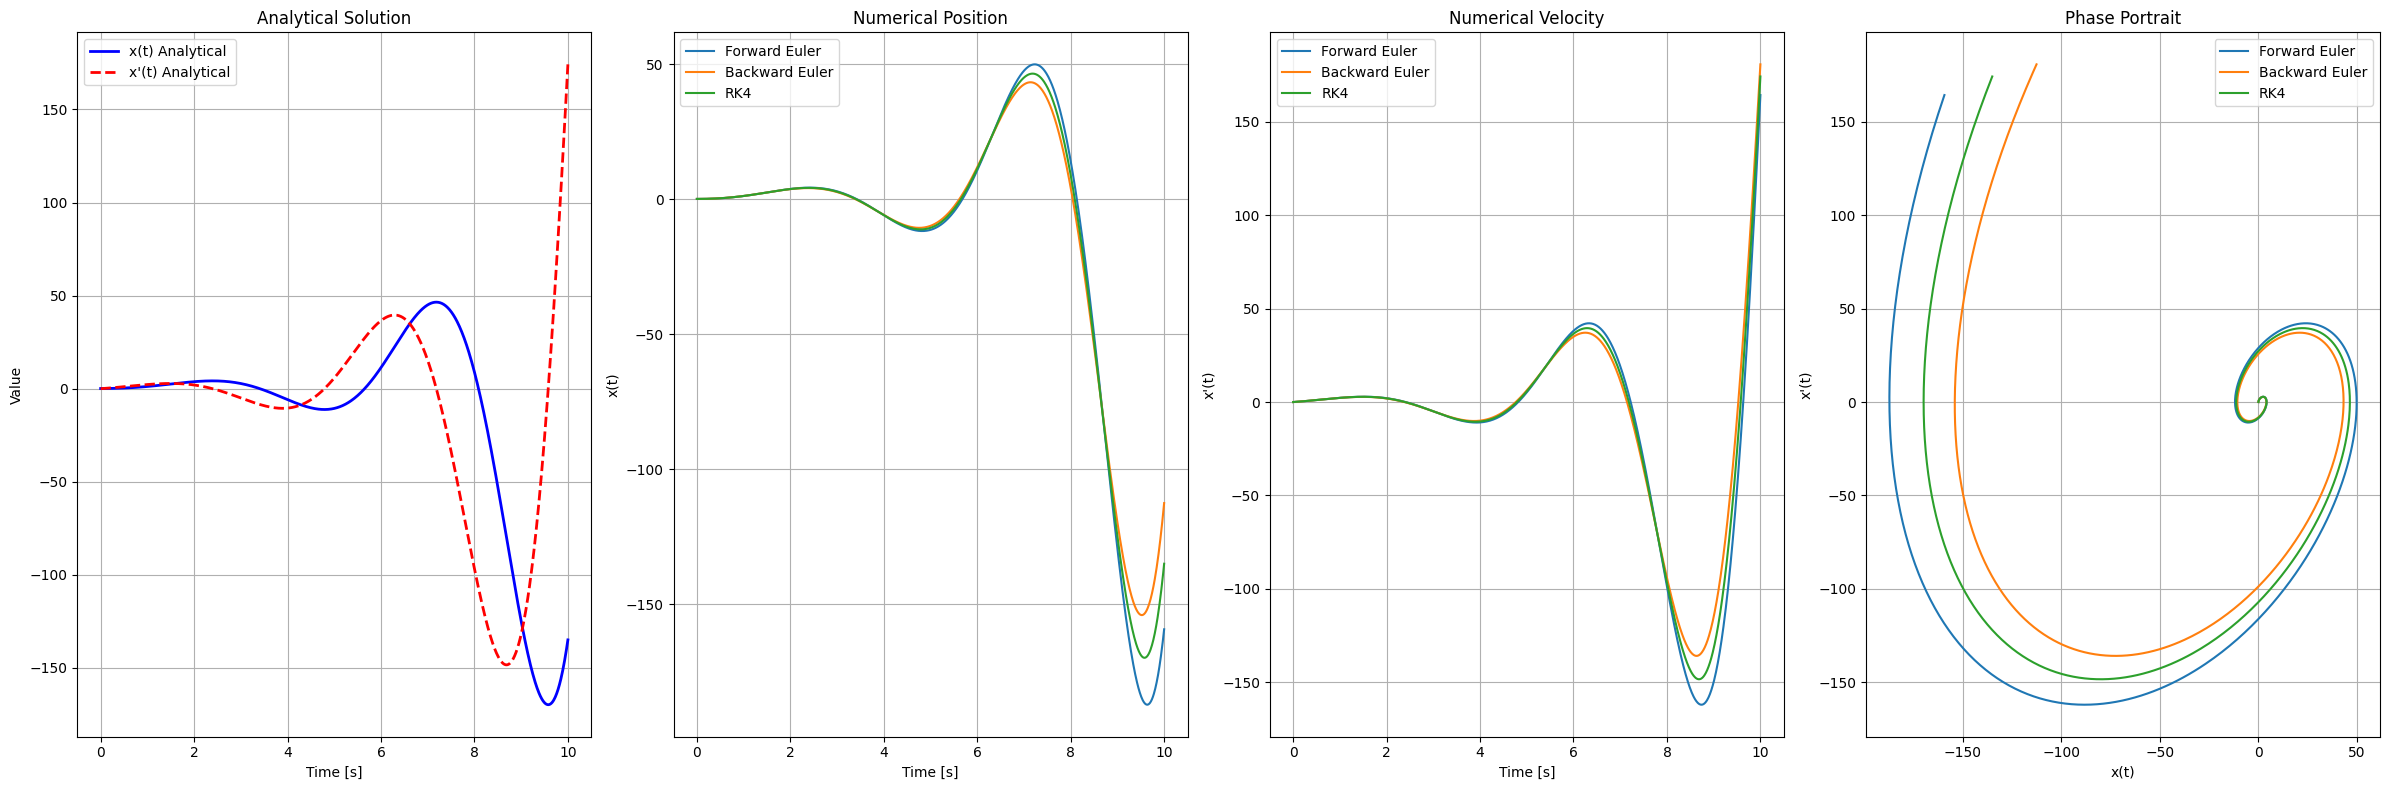

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# System dynamics (ODE -> first-order)
# -----------------------------
a = 4.72
b = -5.21
c = 9.56
d = 9.21

def system_dynamics(x):
    x1 = x[0]
    x2 = x[1]
    dx1 = x2
    dx2 = (d/a) - (b/a)*x2 - (c/a)*x1
    return np.array([dx1, dx2])

# -----------------------------
# Numerical Integrators
# -----------------------------
def forward_euler(fun, x0, Tf, h):
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:,0] = x0
    for k in range(len(t)-1):
        x_hist[:,k+1] = x_hist[:,k] + h*fun(x_hist[:,k])
    return x_hist, t

def backward_euler(fun, x0, Tf, h, tol=1e-8, max_iter=100):
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:,0] = x0
    for k in range(len(t)-1):
        x_hist[:,k+1] = x_hist[:,k]
        for i in range(max_iter):
            x_next = x_hist[:,k] + h*fun(x_hist[:,k+1])
            err = np.linalg.norm(x_next - x_hist[:,k+1])
            x_hist[:,k+1] = x_next
            if err < tol:
                break
    return x_hist, t

def runge_kutta4(fun, x0, Tf, h):
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:,0] = x0
    for k in range(len(t)-1):
        k1 = fun(x_hist[:,k])
        k2 = fun(x_hist[:,k] + 0.5*h*k1)
        k3 = fun(x_hist[:,k] + 0.5*h*k2)
        k4 = fun(x_hist[:,k] + h*k3)
        x_hist[:,k+1] = x_hist[:,k] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return x_hist, t

# -----------------------------
# Analytical solution (improved)
# -----------------------------
def analytical_solution_full(t, a, b, c, d, x0):
    x0_, xdot0_ = x0
    alpha = b / a
    omega2 = c / a
    x_ss = (d/c)
    disc = alpha**2 - 4*omega2

    if disc > 0:  # overdamped
        r1 = (-alpha + np.sqrt(disc))/2
        r2 = (-alpha - np.sqrt(disc))/2
        A = (xdot0_ - r2*(x0_ - x_ss)) / (r1 - r2)
        B = (x0_ - x_ss) - A
        x_t = x_ss + A*np.exp(r1*t) + B*np.exp(r2*t)
        xdot_t = A*r1*np.exp(r1*t) + B*r2*np.exp(r2*t)

    elif np.isclose(disc, 0):  # critically damped
        r = -alpha / 2
        A = x0_ - x_ss
        B = xdot0_ - A*r
        x_t = x_ss + (A + B*t)*np.exp(r*t)
        xdot_t = np.exp(r*t)*(B + r*(A + B*t))

    else:  # underdamped
        mu = -alpha / 2
        omega = np.sqrt(4*omega2 - alpha**2)/2
        C = x0_ - x_ss
        D = (xdot0_ - mu*C)/omega
        x_t = x_ss + np.exp(mu*t)*(C*np.cos(omega*t) + D*np.sin(omega*t))
        xdot_t = np.exp(mu*t)*((D*omega + C*mu)*np.cos(omega*t) + (D*mu - C*omega)*np.sin(omega*t))

    return np.vstack([x_t, xdot_t])

# -----------------------------
# Simulation
# -----------------------------
# Simulation setup
# -----------------------------
x0 = np.array([0.1, 0.0])
Tf = 10.0
h = 0.01
t = np.arange(0, Tf + h, h)

# -----------------------------
x_fe, t_fe = forward_euler(system_dynamics, x0, Tf, h)
x_be, t_be = backward_euler(system_dynamics, x0, Tf, h)
x_rk4, t_rk4 = runge_kutta4(system_dynamics, x0, Tf, h)
x_analytical = analytical_solution_full(t, a, b, c, d, x0)

# -----------------------------
# Compute Errors
# -----------------------------
def compute_errors(x_num, x_true):
    pos_err = np.max(np.abs(x_num[0,:] - x_true[0,:]))
    vel_err = np.max(np.abs(x_num[1,:] - x_true[1,:]))
    rms_pos = np.sqrt(np.mean((x_num[0,:] - x_true[0,:])**2))
    rms_vel = np.sqrt(np.mean((x_num[1,:] - x_true[1,:])**2))
    return pos_err, vel_err, rms_pos, rms_vel

max_fe, max_fe_v, rms_fe, rms_fe_v = compute_errors(x_fe, x_analytical)
max_be, max_be_v, rms_be, rms_be_v = compute_errors(x_be, x_analytical)
max_rk4, max_rk4_v, rms_rk4, rms_rk4_v = compute_errors(x_rk4, x_analytical)

print("Forward Euler: Max x = {:.5f}, Max v = {:.5f}, RMS x = {:.5f}, RMS v = {:.5f}".format(max_fe, max_fe_v, rms_fe, rms_fe_v))
print("Backward Euler: Max x = {:.5f}, Max v = {:.5f}, RMS x = {:.5f}, RMS v = {:.5f}".format(max_be, max_be_v, rms_be, rms_be_v))
print("RK4: Max x = {:.5f}, Max v = {:.5f}, RMS x = {:.5f}, RMS v = {:.5f}".format(max_rk4, max_rk4_v, rms_rk4, rms_rk4_v))

# -----------------------------
# Plots
# -----------------------------
plt.figure(figsize=(24, 8))

# Analytical position and velocity
plt.subplot(1,4,1)
plt.plot(t, x_analytical[0,:], 'b', label='x(t) Analytical', linewidth=2)
plt.plot(t, x_analytical[1,:], 'r--', label="x'(t) Analytical", linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('Value')
plt.title('Analytical Solution')
plt.grid(True)
plt.legend()

# Numerical positions
plt.subplot(1,4,2)
plt.plot(t_fe, x_fe[0,:], label='Forward Euler')
plt.plot(t_be, x_be[0,:], label='Backward Euler')
plt.plot(t_rk4, x_rk4[0,:], label='RK4')
plt.xlabel('Time [s]')
plt.ylabel('x(t)')
plt.title('Numerical Position')
plt.grid(True)
plt.legend()

# Numerical velocities
plt.subplot(1,4,3)
plt.plot(t_fe, x_fe[1,:], label='Forward Euler')
plt.plot(t_be, x_be[1,:], label='Backward Euler')
plt.plot(t_rk4, x_rk4[1,:], label='RK4')
plt.xlabel('Time [s]')
plt.ylabel("x'(t)")
plt.title('Numerical Velocity')
plt.grid(True)
plt.legend()

# Phase Portrait
plt.subplot(1,4,4)
plt.plot(x_fe[0,:], x_fe[1,:], label='Forward Euler')
plt.plot(x_be[0,:], x_be[1,:], label='Backward Euler')
plt.plot(x_rk4[0,:], x_rk4[1,:], label='RK4')
plt.xlabel('x(t)')
plt.ylabel("x'(t)")
plt.title('Phase Portrait')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()